# Sentiment Classifier

This notebook contains code for XGBoost to classify the vector representations of sentences.

### Import Libraries

In [352]:
!pip install xgboost

In [353]:
import pandas as pd

import xgboost
from sklearn import metrics

In [354]:
import warnings
warnings.filterwarnings("ignore")

### Input

In [355]:
df_positive = pd.read_csv('positive.csv')
df_positive['y'] = 1

df_negative = pd.read_csv('negative.csv')
df_negative['y'] = 0

df_train = pd.concat([df_positive, df_negative], axis=0, ignore_index=True, sort=False).drop(columns=['Unnamed: 0'])
df_train = df_train.sample(frac=1, random_state=29).reset_index(drop=True)
df_train

x_train, y_train = df_train.drop('y', axis=1), df_train['y']

In [356]:
df_positive_gen = pd.read_csv('positive_generated.csv')
df_positive_gen['y'] = 1

df_negative_gen = pd.read_csv('negative_generated.csv')
df_negative_gen['y'] = 0

df_test = pd.concat([df_positive_gen, df_negative_gen], axis=0, ignore_index=True, sort=False).drop(columns=['Unnamed: 0'])
df_test = df_test.sample(frac=1, random_state=29).reset_index(drop=True)
df_test

x_test, y_test = df_test.drop('y', axis=1), df_test['y']

In [359]:
xgb = xgboost.XGBClassifier(n_estimators=80, learning_rate=0.015, max_depth=5, colsample_bytree=0.6, subsample=0.3, gamma=0.5, min_child_weight=1)
training_start = time.perf_counter()
xgb.fit(x_train, y_train)
training_end = time.perf_counter()

prediction_start = time.perf_counter()
preds = xgb.predict(x_test)
prediction_end = time.perf_counter()

acc_xgb = (preds == y_test).sum().astype(float) / len(preds)*100
xgb_train_time = training_end-training_start
xgb_prediction_time = prediction_end-prediction_start

print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))
print("Time consumed for training: %4.3f" % (xgb_train_time))
print("Time consumed for prediction: %6.5f seconds" % (xgb_prediction_time))
preds

XGBoost's prediction accuracy is: 80.00
Time consumed for training: 0.061
Time consumed for prediction: 0.00190 seconds


array([1, 0, 1, 1, 1, 1, 0, 1, 1, 0])

Accuracy: 80.00%


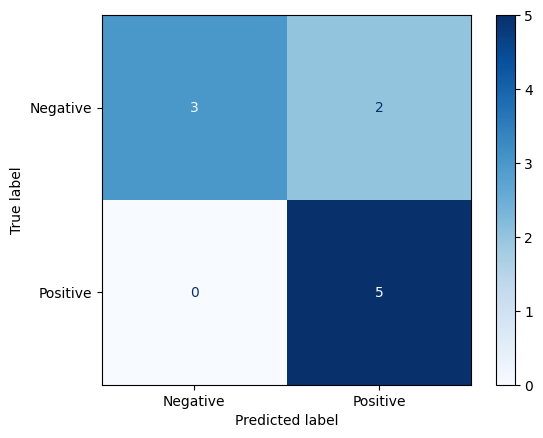

In [360]:
accuracy = metrics.accuracy_score(y_test, preds)
print(f"Accuracy: {accuracy*100:.2f}%")


confusion_matrix = metrics.confusion_matrix(y_test, preds)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Negative", "Positive"])

cm_display.plot(cmap=plt.cm.Blues)